In [1]:
# =========================
# CELL 1 – Imports & paths
# =========================

import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay,
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)

import joblib

plt.style.use("ggplot")
sns.set(font_scale=1.1)

DATA_DIR = Path("../data")
MODEL_DIR = Path("../models")


In [12]:
from pathlib import Path
import joblib

# This should match what you used in Notebook 2
MODEL_DIR = Path("../models")

model_paths = {
    "logistic_regression": MODEL_DIR / "/content/logistic_regression_best.joblib",
    "random_forest": MODEL_DIR / "/content/random_forest_best.joblib",
    "xgboost": MODEL_DIR / "/content/xgboost_best.joblib",
}

models = {name: joblib.load(path) for name, path in model_paths.items()}

print("Loaded models:", list(models.keys()))


Loaded models: ['logistic_regression', 'random_forest', 'xgboost']


In [13]:
import os

for root, dirs, files in os.walk("/", topdown=True):
    for f in files:
        if f.endswith("_best.joblib"):
            print(os.path.join(root, f))


/content/xgboost_best.joblib
/content/logistic_regression_best.joblib
/content/random_forest_best.joblib


In [14]:
# ==============================================
# CELL 2 – Load data & recreate train/test split
# ==============================================

provider_df = pd.read_csv(DATA_DIR / "/content/provider_level_dataset.csv")

y = provider_df["is_fraud"].astype(int)
id_cols = [c for c in provider_df.columns if c.lower() in {"provider"}]
X = provider_df.drop(columns=["is_fraud"] + id_cols, errors="ignore")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_test.shape, y_test.value_counts()


((1082, 14),
 is_fraud
 0    981
 1    101
 Name: count, dtype: int64)

In [9]:
# ======================================
# CELL 3 – Load best saved models
# ======================================

model_paths = {
    "logistic_regression": MODEL_DIR / "/content/logistic_regression_best.joblib",
    "random_forest": MODEL_DIR / "/content/random_forest_best.joblib",
    "xgboost": MODEL_DIR / "/content/xgboost_best.joblib",
}

models = {name: joblib.load(path) for name, path in model_paths.items()}
list(models.keys())


['logistic_regression', 'random_forest', 'xgboost']


=== LOGISTIC_REGRESSION ===


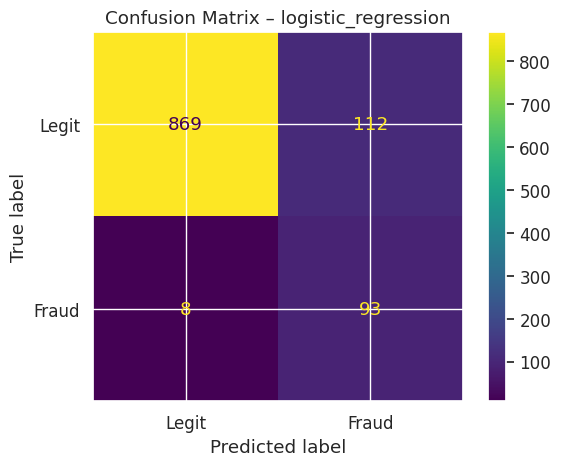


=== RANDOM_FOREST ===


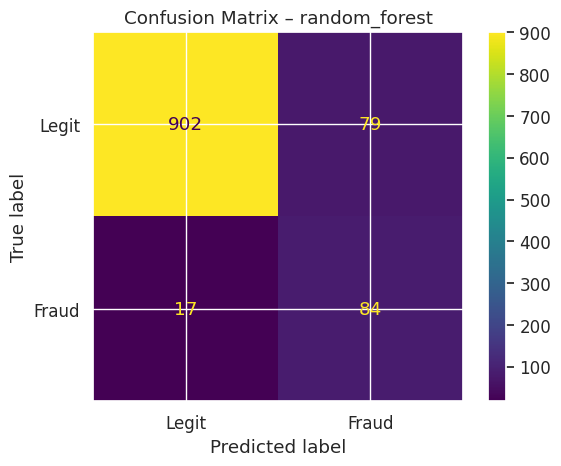


=== XGBOOST ===


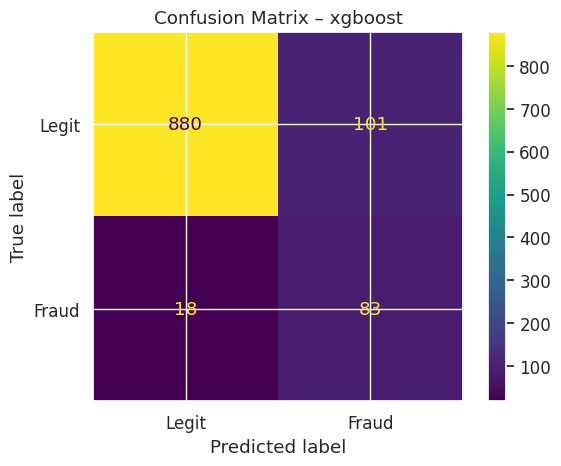

,precision,recall,f1,roc_auc,pr_auc
model,,,,,
logistic_regression,0.453659,0.920792,0.607843,0.962142,0.775664
random_forest,0.515337,0.831683,0.636364,0.963212,0.764987
xgboost,0.451087,0.821782,0.582456,0.952201,0.739400


In [15]:
# =======================================
# CELL 4 – Metrics & confusion matrices
# =======================================

def compute_metrics_and_cm(model, X_te, y_te, name):
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:, 1]

    metrics = {
        "model": name,
        "precision": precision_score(y_te, y_pred, zero_division=0),
        "recall": recall_score(y_te, y_pred, zero_division=0),
        "f1": f1_score(y_te, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_te, y_proba),
        "pr_auc": average_precision_score(y_te, y_proba),
    }

    cm = confusion_matrix(y_te, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Legit", "Fraud"])
    disp.plot()
    plt.title(f"Confusion Matrix – {name}")
    plt.show()

    return metrics

all_metrics = []

for name, model in models.items():
    print(f"\n=== {name.upper()} ===")
    m = compute_metrics_and_cm(model, X_test, y_test, name)
    all_metrics.append(m)

metrics_df = pd.DataFrame(all_metrics).set_index("model")
metrics_df


<Figure size 700x500 with 0 Axes>

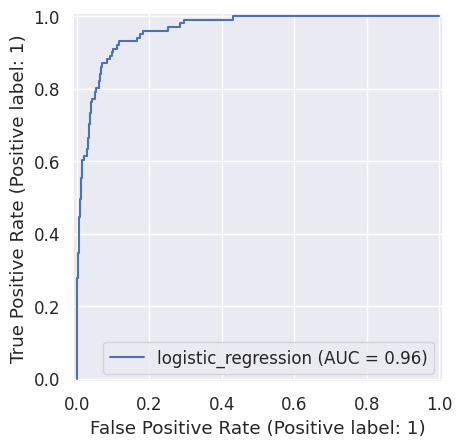

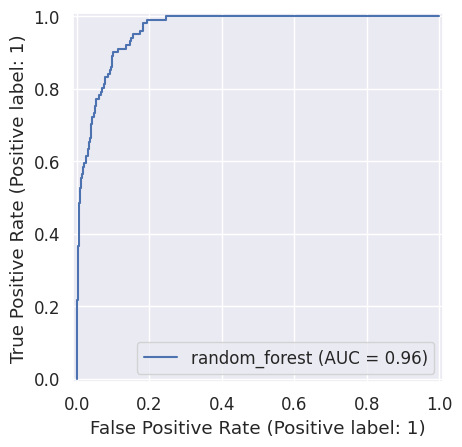

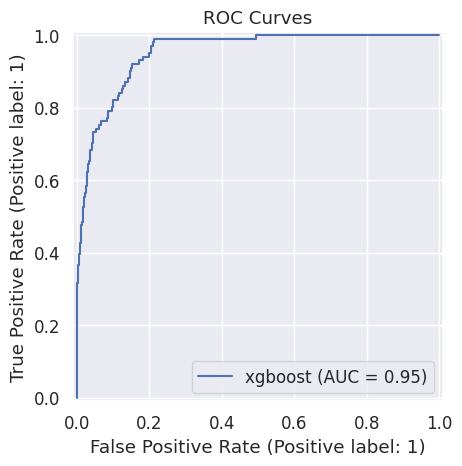

<Figure size 700x500 with 0 Axes>

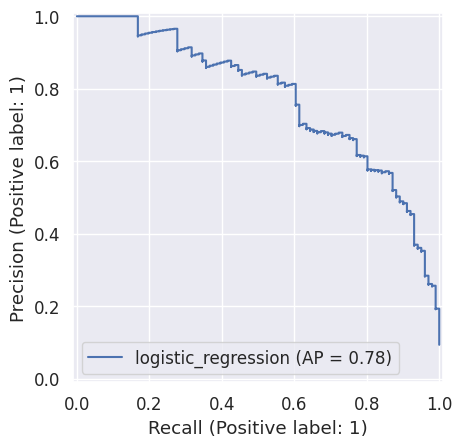

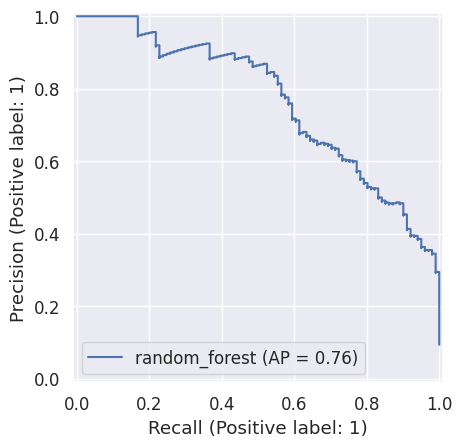

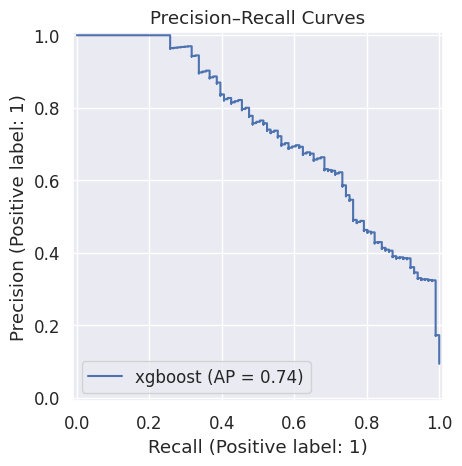

In [16]:
# ====================================
# CELL 5 – ROC & PR curves comparison
# ====================================

plt.figure(figsize=(7, 5))
for name, model in models.items():
    RocCurveDisplay.from_estimator(model, X_test, y_test, name=name)
plt.title("ROC Curves")
plt.show()

plt.figure(figsize=(7, 5))
for name, model in models.items():
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name=name)
plt.title("Precision–Recall Curves")
plt.show()


In [17]:
# =====================================
# CELL 6 – Error analysis: FP & FN rows
# =====================================

best_model_name = metrics_df["f1"].idxmax()
best_model = models[best_model_name]
print("Using best model for error analysis:", best_model_name)

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

test_index = X_test.index

fp_mask = (y_test == 0) & (y_pred == 1)  # false positives
fn_mask = (y_test == 1) & (y_pred == 0)  # false negatives

fp_cases = provider_df.loc[test_index[fp_mask]].copy()
fn_cases = provider_df.loc[test_index[fn_mask]].copy()

print("\nTop 3 False Positives (legit providers flagged as fraud):")
display(fp_cases.head(3))

print("\nTop 3 False Negatives (fraud providers missed):")
display(fn_cases.head(3))


Using best model for error analysis: random_forest

Top 3 False Positives (legit providers flagged as fraud):


,InscClaimAmtReimbursed_sum,InscClaimAmtReimbursed_mean,InscClaimAmtReimbursed_max,ClaimDuration_days_mean,ClaimDuration_days_max,is_inpatient_sum,is_outpatient_sum,BeneID_nunique,ClaimID_nunique,total_claims,unique_beneficiaries,inpatient_share,outpatient_share,claims_per_beneficiary,is_fraud
4648,220900,8836.000000,57000,6.440000,35,24,1,23,25,25,23,0.960000,0.040000,1.086957,0
2301,170480,738.008658,28000,1.419913,20,9,222,142,231,231,142,0.038961,0.961039,1.626761,0
3876,416040,1762.881356,87000,1.533898,20,18,218,153,236,236,153,0.076271,0.923729,1.542484,0



Top 3 False Negatives (fraud providers missed):


,InscClaimAmtReimbursed_sum,InscClaimAmtReimbursed_mean,InscClaimAmtReimbursed_max,ClaimDuration_days_mean,ClaimDuration_days_max,is_inpatient_sum,is_outpatient_sum,BeneID_nunique,ClaimID_nunique,total_claims,unique_beneficiaries,inpatient_share,outpatient_share,claims_per_beneficiary,is_fraud
2242,303480,4101.081081,22000,2.837838,35,32,42,74,74,74,74,0.432432,0.567568,1.000000,1
4449,68110,386.988636,12000,0.982955,20,1,175,63,176,176,63,0.005682,0.994318,2.793651,1
2102,245450,274.552573,14030,0.919463,20,0,894,395,894,894,395,0.000000,1.000000,2.263291,1


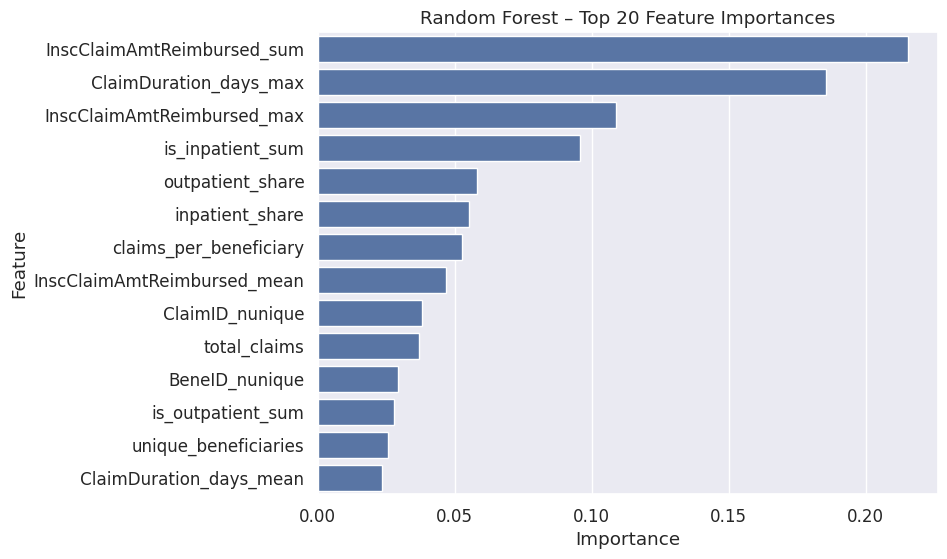

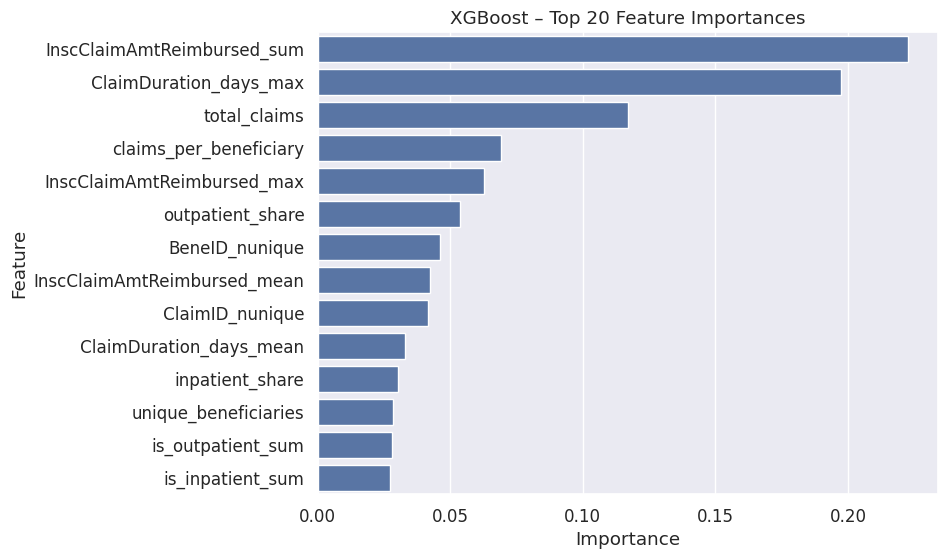

In [18]:
# ===================================
# CELL 7 – Feature importance (models)
# ===================================

feature_names = X.columns

# Random Forest importance
if "random_forest" in models:
    rf = models["random_forest"].named_steps["clf"]
    importances = rf.feature_importances_
    rf_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)

    plt.figure(figsize=(8, 6))
    sns.barplot(x=rf_imp.values, y=rf_imp.index)
    plt.title("Random Forest – Top 20 Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

# XGBoost importance
if "xgboost" in models:
    xgb = models["xgboost"].named_steps["clf"]
    xgb_imp = pd.Series(xgb.feature_importances_, index=feature_names).sort_values(ascending=False).head(20)

    plt.figure(figsize=(8, 6))
    sns.barplot(x=xgb_imp.values, y=xgb_imp.index)
    plt.title("XGBoost – Top 20 Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
